In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from keras.utils import np_utils
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Input

batch_size = 32 #Lote ok
nb_classes = 8  # values = 2 or 8
epochs = 100
img_rows, img_cols = 32,32 # Scaling input image to theses dimensions
activation = "relu"
patience=10
optimizer='adam'
shape=(img_rows,img_cols,3)

def format_example(image):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (img_rows, img_cols))
    return image


def load_data(name="colorectal_histology"):
  train_ds = tfds.load(name, split=tfds.Split.TRAIN, batch_size=-1)
  train_ds['image'] = tf.map_fn(format_example, train_ds['image'], dtype=tf.float32)
  numpy_ds = tfds.as_numpy(train_ds)
  X, y = numpy_ds['image'], numpy_ds['label']

  return np.array(X), np.array(y)

def plot_symbols(X,y,n=15):
  index = np.random.randint(len(y), size=n)
  plt.figure(figsize=(25, 2))
  for i in np.arange(n):
      ax = plt.subplot(1,n,i+1)
      plt.imshow(X[index[i],:,:,:])
      plt.gray()
      ax.set_title(f'{y[index[i]]}-{index[i]}')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

    #
# Build an ANN structure - LeNet5
#
def cnn_model():
    #
    # Neural Network Structure
    #
    
    # model = Sequential()
    
    # model.add(layers.Conv2D(8, (5, 5)))
    # model.add(layers.Activation(activation))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # model.add(layers.Conv2D(16, (5, 5)))
    # model.add(layers.Activation(activation))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
    # model.add(layers.Flatten())
    
    # model.add(layers.Dense(256))
    # model.add(layers.Activation(activation))
    
    # model.add(layers.Dense(64))
    # model.add(layers.Activation(activation))

    # model.add(layers.Dense(32))
    # model.add(layers.Activation(activation))

    # model.add(layers.Dense(nb_classes))
    # model.add(layers.Activation('softmax'))


  #Linear
    input = Input(shape=shape)
    # x = layers.Conv2D(32, kernel_size=(3,3), activation=activation)(input)
    # x = layers.MaxPooling2D(pool_size=(2,2))(x)
    # x = layers.Conv2D(32,kernel_size=(4,4), activation=activation)(x)
    # x = layers.MaxPooling2D(pool_size=(2,2))(x)
    # x = layers.Flatten()(x)
    # x = layers.Dense(8,'softmax')(x)


  #Non-Linear
    x = layers.Conv2D(32, kernel_size=(3,3), activation=activation)(input)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    b1 = layers.Conv2D(32, kernel_size=(4,4),activation=activation)(x)
    b1 = layers.MaxPooling2D(pool_size=(2,2))(b1)

    b2 = layers.Conv2D(32,kernel_size=(3,3),activation=activation)(x)
    b2 = layers.MaxPooling2D(pool_size=(2,2))(b2)
    b2 = layers.Dense(16)(b2)

    x = layers.Concatenate()([b2,b1])
    x = layers.Flatten()(x)
    x = layers.Dense(8,'softmax')(x)

    model = Model(inputs=input,outputs=x)

    return model



(5000, 32, 32, 3) train samples
32 x 32 image size
100 epochs


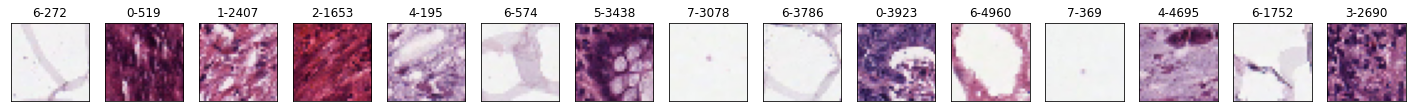

fold 1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 15, 15, 32)   0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 13, 13, 32)   9248        ['max_pooling2d[0][0]']          
                                                                                       

In [4]:
##################################################################################
# Main program

X, y = load_data()

print(X.shape, 'train samples')
print(img_rows,'x', img_cols, 'image size')
print(epochs,'epochs')

if nb_classes==2:
  y[y>0] = 1


plot_symbols(X, y, 15)


pd.DataFrame({'ncount':pd.Series(y).value_counts(), '% ncount':pd.Series(y).value_counts(normalize=True)*100})



#Codigo que se daba inicialmente
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# print(f'X_train {X_train.shape} X_test {X_test.shape}')
# print(f'y_train {y_train.shape} y_test {y_test.shape}')

#Usando StratifiedKfold hacer cross validation
i=0
skf = StratifiedKFold(n_splits = 10, random_state = 890, shuffle= True)

aucResults=[]
f1Results = []
### Bucle
start_time = time.time()
for train_index, test_index in skf.split(X,y):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  print('fold {}'.format(i+1))
  i+=1

  model = cnn_model()
  model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=[tf.keras.metrics.AUC()])
  #early_stopping = EarlyStopping(monitor='val_loss', patience=10)
  #print(X_train.shape, y_train.shape)
  #np.reshape(X_train, y_train.shape)
  y_test2 = np_utils.to_categorical(y_test,nb_classes)
  y_train2 = np_utils.to_categorical(y_train,nb_classes)


  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
  print(model.summary())

  #model.fit(X_train, y_Train2, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=2) #, callbacks=[early_stopping])
  history = model.fit(X_train, y_train2, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=2, callbacks=[callback])

  print(model.summary())

  loss, acc = model.evaluate(X_test, y_test2, batch_size=batch_size)
  print(f'loss: {loss:.2f} acc: {acc:.2f}')
  scores = (loss,acc)


  # Output prediction for the first five X_test images
  model.predict(X_test[:5], batch_size=batch_size)

  y_scores = model.predict(X_test) # Confidence prediction per class
  y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction

  print('#######################################')
  if nb_classes ==  2:
    auc = round(metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)),4)
    aucResults.append(auc)
    print(f'AUC {auc} ')

    
  else:
    print(f'AUC {metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"):.4f} ')
    AUC = metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr")
    aucResults.append(round(AUC,4))
  print('#######################################')

  print('Predictions', pd.Series(y_pred).value_counts(),'\n')

  print('Confusion matrix')
  print(metrics.confusion_matrix(y_test,y_pred),'\n')

  target_names = ['TUMOR', 'HEALTHY'] if nb_classes ==  2 else ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']

  result = metrics.classification_report(y_test, y_pred, target_names=target_names)
  f1 = round(metrics.f1_score(y_test, y_pred,average='macro'),4)
  print(result)
  #print("F1: ",f1)
  f1Results.append(f1)

print('Optimizador: ',optimizer)
print('Activacion: ',activation)
print('Train samples: ',X.shape)
print('Image size: ',img_rows,'x', img_cols)
print('Batch size: ',batch_size)
print('Epochs: ',epochs)
print('Patience: ',patience)
print('AUCs: ',aucResults)
print('F1 Scores: ',f1Results)
print('Tiempo: ',time.time()-start_time)
